# Loading and Visualizing the data

In [2]:
import cv2
import helpers

import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping # this for loading images

%matplotlib inline

In [3]:
# Image data directories

IMAGE_DIR_TRAINING = "traffic_light_images/training/"
IMAGE_DIR_TEST = "traffic_light_images/test/"

In [4]:
# use the load_data function we defiend in helpers.py
# Load training data

IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TRAINING)

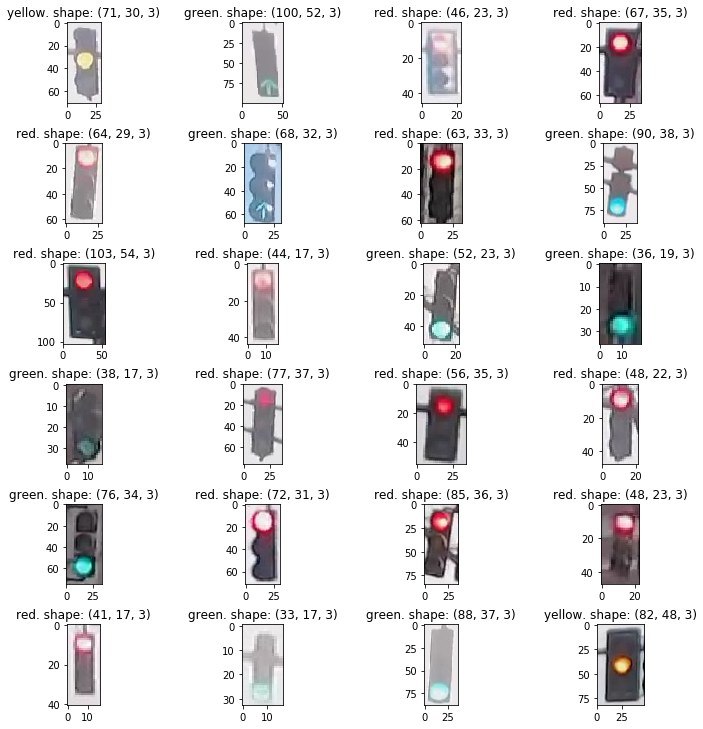

In [5]:
# definition of 3 possible traffic light states and their label
#----------------Global definitions-----------------------
tl_states = ["red","yellow","green"]
tl_state_red = 0
tl_state_yellow = 1
tl_state_green = 2
tl_state_count = 3
tl_state_red_string = tl_states[tl_state_red]
tl_state_yellow_string = tl_states[tl_state_yellow]
tl_state_green_string = tl_states[tl_state_green]

# index of image and label in image set
image_data_image_index = 0
image_data_label_index = 1

# normalized image size
default_image_size = 32
#------------------End of global definitions-------------

fig = plt.figure(figsize=(10,40))

example_count = 24 
if example_count>len(IMAGE_LIST):
    example_count = len(IMAGE_LIST)

chosen = set()

# print out 24 random examples, prevent double choice
for example_index in range(example_count):
    tries = 0
    
    while tries < 2:
        index = 0
        tries += 1
        if example_index==0: # first choice shoule be a yellow light
            for iterator in range(len(IMAGE_LIST)): 
                if IMAGE_LIST[iterator][image_data_label_index]==tl_state_yellow_string:
                    index = iterator
                    break
        else: # all other choice are random 
            index = random.randint(0,len(IMAGE_LIST) -1)
            
        if index in chosen: # try second time if chosen already
            continue
        chosen.add(index)
    
    example_image = IMAGE_LIST[index][image_data_image_index]
    result = "{}. shape: {}".format(IMAGE_LIST[index][image_data_label_index],example_image.shape)
    ax = fig.add_subplot(example_count, 4, example_index+1, title = result)
    ax.imshow(example_image.squeeze())
    
fig.tight_layout(pad=0.7)



# 2. Pre-process the Data

In [6]:
# this function should take in an RGB image and return a new, standardized version
def standardize_input(image):
    
    standard_im = cv2.resize(image.astype('uint8'),dsize=(default_image_size,default_image_size))
    return standard_im


In [7]:
# create a one-hot encoded label that works for all classes of traffic lights
def one_hot_encode(label):
    
    one_hot_encoded = [0,0,0]
    for state_index in range(tl_state_count):
        if label==tl_states[state_index]:
            one_hot_encoded[state_index] = 1
            
    return one_hot_encoded
print(one_hot_encode("red"))
print(one_hot_encode("yellow"))
print(one_hot_encode("green"))

[1, 0, 0]
[0, 1, 0]
[0, 0, 1]


In [8]:
# Construct a standardized_list of input images and output labels
def standardize(image_list):
    
    # Empty image data array
    standard_list = []
    
    # Iterate through all the image-label pairs
    for item in image_list:
        image = item[0]
        label = item[1]
        
        # standardize the image
        standardize_im = standardize_input(image)
        
        # one-hot encode the label
        one_hot_label = one_hot_encode(label)
        
        # Append the image, and it's one hot encoded label to the full, processed list of image data
        standard_list.append((standardize_im, one_hot_label))
        
    return standard_list

# standardize all training imgaes

STANDARDIZED_LIST = standardize(IMAGE_LIST)       

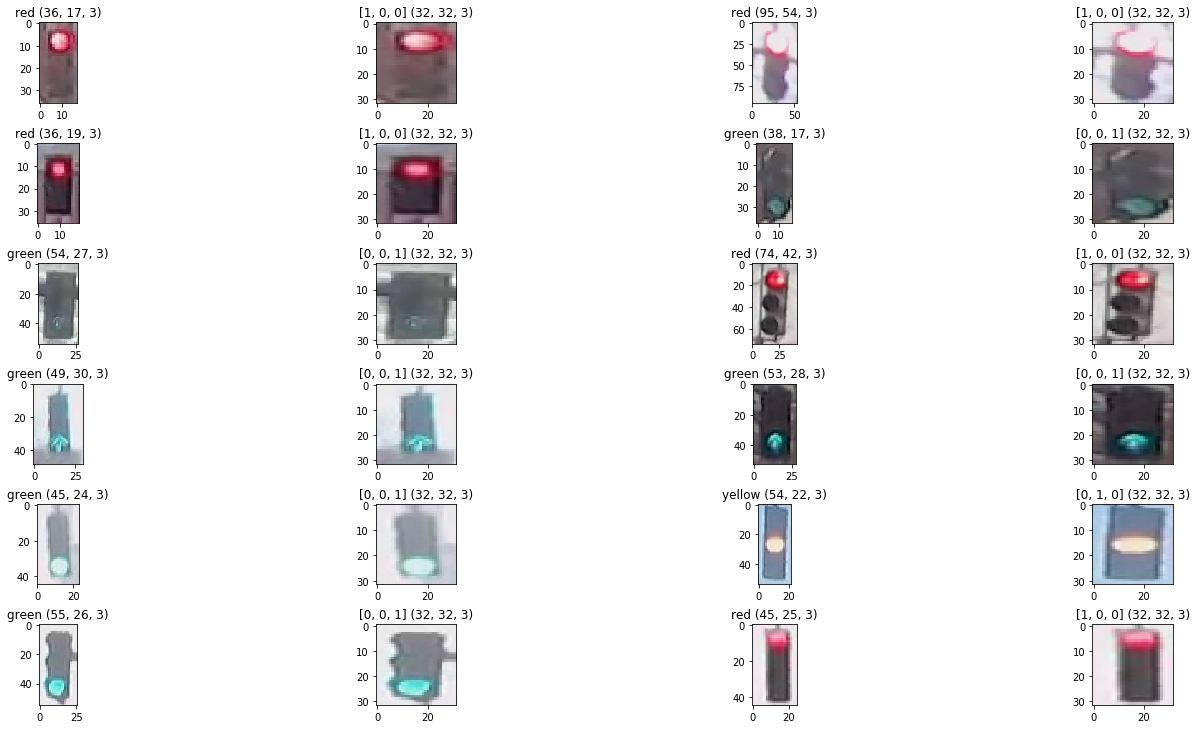

In [9]:
# visualize the standardized data

fig = plt.figure(figsize=(20,40))

# 12 example pairs
example_count = 12 
if example_count>len(IMAGE_LIST):
    example_count = len(IMAGE_LIST)
total_count = example_count*2

chosen = set() # use set to prevent duplicate items

for example_index in range(example_count):
    
    tries = 0
    index = 0
    
    # select next image
    while tries < 2:
        tries += 1
        index = random.randint(0,len(IMAGE_LIST)-1)
        
        if index in chosen:
            continue
        chosen.add(index)
        
    eff_index = example_index*2
    
    # Print original 
    example_image = IMAGE_LIST[index][image_data_image_index]
    result = "{} {}".format(IMAGE_LIST[index][image_data_label_index],example_image.shape)
    ax = fig.add_subplot(total_count, 4, eff_index+1, title = result)
    ax.imshow(example_image.squeeze())
    
    # Print standardized counterpiece
    eff_index += 1
    example_image = STANDARDIZED_LIST[index][image_data_image_index]
    result = "{} {}".format(STANDARDIZED_LIST[index][image_data_label_index],example_image.shape)
    ax = fig.add_subplot(total_count,4,eff_index+1, title=result)
    ax.imshow(example_image.squeeze())
    
fig.tight_layout(pad=0.7)
    

# 3. Feature Extraction

Label [red, yellow, green]: [1, 0, 0]


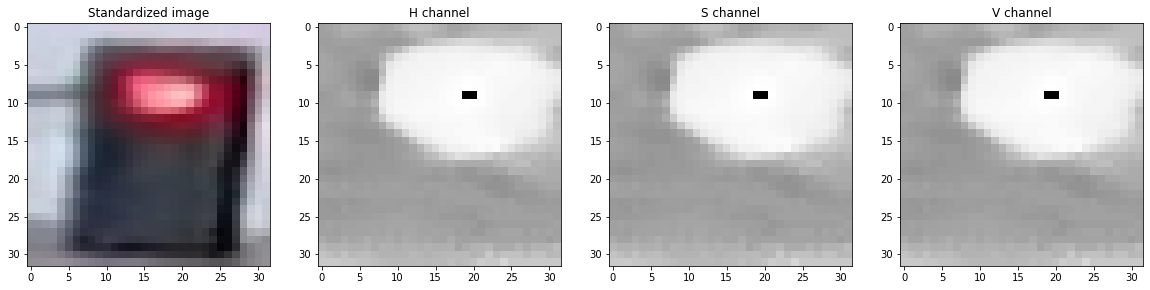

In [10]:
# RGB to HSV conversion
# Visualize the individual color channels

image_num = 0
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]

# Convert to HSV
hsv = cv2.cvtColor(test_im,cv2.COLOR_RGB2HSV)

# print image label
print('Label [red, yellow, green]: ' + str(test_label))

# HSV channels
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

# plot the original image and the three channels
f,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,10))
ax1.set_title('Standardized image')
ax1.imshow(test_im)
ax2.set_title('H channel')
ax2.imshow(h,cmap = 'gray')
ax3.set_title('S channel')
ax3.imshow(h,cmap = 'gray')
ax4.set_title('V channel')
ax4.imshow(h,cmap = 'gray')

Image index: 336
[1, 0, 0]


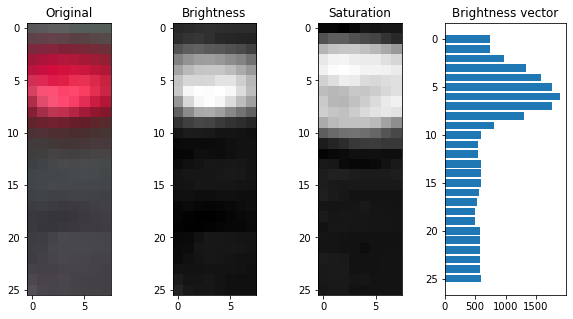

In [11]:
import math 

# crop settings, remove as much as possible to prevent too much influence by objects near the traffic light
crop_left_right = 12
crop_top_bottom = 3

def mask_image_get_brightness_vector(rgb_image):
    '''
    Tries to identify highlights within the traffic light's inner region and removes a vector with the brightness history 
    from top to bottom
    
    input: rgb_image
    output: the history vector
    '''
    hsv = cv2.cvtColor(rgb_image,cv2.COLOR_RGB2HSV)
    hsv = hsv[crop_top_bottom:default_image_size-crop_top_bottom,crop_left_right:default_image_size-crop_left_right]
    brightness = hsv[:,:,2]
    summed_brightness = np.sum(brightness,axis = 1)
    
    return (brightness, hsv[:,:,1], summed_brightness )

# Create a brightness feature that takes in an RGB image and outputs a feature vector and value this feature
# should use HSV colorspace values

def create_feature(rgb_image):
    '''
    input: An RGB image of a traffic light
    output: The brightness mask, the saturation mask, the brightness history vector from top to bottom
    '''
    
    (img_bright,img_sat,sb) = mask_image_get_brightness_vector(rgb_image)
    
    feature = sb
    
    return feature 

# Show an example image
image_num = random.randint(0,len(STANDARDIZED_LIST)-1)
print("Image index: {}".format(image_num))
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]
print(test_label)

img_bright, img_sat,sb = mask_image_get_brightness_vector(test_im)

cropped_org = test_im[crop_top_bottom:default_image_size-crop_top_bottom,crop_left_right:default_image_size-crop_left_right]

# show details of example image
f, (org, bright, sat, b) = plt.subplots(1, 4, figsize=(10,5))
org.set_title("Original")
bright.set_title("Brightness")
sat.set_title("Saturation")
b.set_title("Brightness vector")
org.imshow(cropped_org)
bright.imshow(img_bright, cmap='gray')
sat.imshow(img_sat, cmap='gray')
b.barh(range(len(sb)), sb)
b.invert_yaxis()
plt.show()


Image index: 698
[1, 0, 0]
By dominance detected color:red ([0.21153846 0.         0.        ])


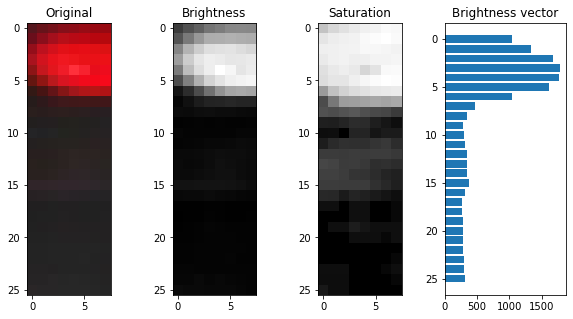

In [12]:
# create more image analysis and create more features

def get_color_dominance(rgb_image):
    '''
    input: the traffic light image
    output: A vector containing the percentage of red, yellow and green, within the image
    '''
    agg_colors = [0,0,0]
    
    cropped_image = rgb_image[crop_top_bottom:default_image_size-crop_top_bottom, crop_left_right:default_image_size-crop_left_right]
    threshold_min = 140
    threshold_min_b = 120
    threshold_rel = 0.75
    total_pixels = len(cropped_image)*len(cropped_image[1])
    
    for row_index in range(len(cropped_image)):
        cur_row = cropped_image[row_index]
        for col_index in range(len(cropped_image[0])):
            pixel = cur_row[col_index]
            if pixel[0]>threshold_min and pixel[1]<pixel[0]*threshold_rel and pixel[2] < pixel[0]*threshold_rel:
                agg_colors[0] += 1
            if pixel[0]>threshold_min and pixel[1]>threshold_min and pixel[2]<pixel[0] * threshold_rel:
                agg_colors[1] += 1
            if pixel[1]>threshold_min and pixel[0]<pixel[1]*threshold_rel and pixel[2]>threshold_min_b:
                agg_colors[2] += 1
    agg_colors = np.array(agg_colors)/float(total_pixels)
    
    return agg_colors

# Display an example image
image_num = random.randint(0,len(STANDARDIZED_LIST)-1)
print("Image index: {}".format(image_num))
test_im = STANDARDIZED_LIST[image_num][0]
test_label = STANDARDIZED_LIST[image_num][1]
print(test_label)

img_bright, img_sat, sb = mask_image_get_brightness_vector(test_im)

cropped_org = test_im[crop_top_bottom:default_image_size-crop_top_bottom,crop_left_right:default_image_size-crop_left_right]

agg_colors = get_color_dominance(test_im)

# Try to identify the image by dominant colors
dominant = np.argmax(agg_colors)

# Thresholds for dominant colors
dominant_sure_threshold = 0.15
dominant_threshold = 0.015

if agg_colors[dominant] > dominant_threshold:
    print("By dominance detected color:{} ({})".format(tl_states[dominant],agg_colors))
else:
    print("No dominant color detected")

# Show details of example image
f, (org, bright, sat, b) = plt.subplots(1, 4, figsize=(10,5))
org.set_title("Original")
bright.set_title("Brightness")
sat.set_title("Saturation")
b.set_title("Brightness vector")
org.imshow(cropped_org)
bright.imshow(img_bright, cmap='gray')
sat.imshow(img_sat, cmap='gray')
b.barh(range(len(sb)), sb)
b.invert_yaxis()
plt.show()
    

# 4. Classification and Visualizing Error

Image index: 1067
26
[0, 0, 1]


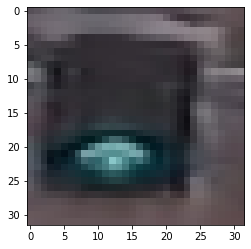

In [13]:
def estimate_label(rgb_image):
    
    # get the brightness vector feature first, this is a great fallback in any case
    feature = create_feature(rgb_image)
    print(len(feature))
    # search for a visually dominant color as well 
    dominant = get_color_dominance(rgb_image)
    
    max_dominant = np.argmax(dominant)
    
    one_hot = [0,0,0]
    
    maxc = len(feature) // 3*3
    div = maxc //3
    prob = [np.sum(feature[0:div]),np.sum(feature[div:2*div]),np.sum(feature[2*div:3*div])]
    
    one_hot[np.argmax(prob)] = 1
    
    red_yellow_tolerance = 0.8
    
    if(dominant[max_dominant]>dominant_threshold): 
        if max_dominant == tl_state_red or max_dominant==tl_state_yellow:
            val = dominant[max_dominant]
            scaled_val = val*red_yellow_tolerance
            if scaled_val<dominant[0] and scaled_val<dominant[1]:
                return one_hot
        one_hot = [0,0,0]
        one_hot[max_dominant] = 1
        return one_hot
    
    return one_hot

image_num = random.randint(0,len(STANDARDIZED_LIST)-1)
print("Image index: {}".format(image_num))
test_im = STANDARDIZED_LIST[image_num][0]

label = estimate_label(test_im)
print(label)
plt.imshow(test_im)


In [14]:
# using the load_dataset function in helpers.py
TEST_IMAGE_LIST = helpers.load_dataset(IMAGE_DIR_TEST)

# standardize the test data
STANDARDIZED_TEST_LIST = standardize(TEST_IMAGE_LIST)

# shuffle the standardized test data
random.shuffle(STANDARDIZED_TEST_LIST)

# 5. Evaluate model and determine the Accuracy

In [47]:
# Constructs a list of misclassified images given a list of test images and their labels 

def get_misclassified_images(test_images):
    # Track misclassified images by placing them into a list
    misclassified_images_labels = []
    
    # Iterate through all the test images
    # Classify each image and compare to the true label
    for image in test_images:
        
        # get true data 
        im = image[0]
        true_label = image[1]
        assert(len(true_label) == 3), "The true_label is not the expected length(3)."
        
        # get predicted label from your classifier
        predicted_label = estimate_label(im)
        assert(len(predicted_label) == 3), "The predicted_label is not the expected length(3)."
        
        # compare true and predicted labels
        if(predicted_label != true_label):
            misclassified_images_labels.append((im,predicted_label, true_label))
    return misclassified_images_labels

# Find all misclassified images in a given test set
MISCLASSIFIED = get_misclassified_images(STANDARDIZED_TEST_LIST)

# Accuracy calculations
total = len(STANDARDIZED_TEST_LIST)
num_correct = total - len(MISCLASSIFIED)
accuracy = num_correct/total
opencv_accuracy = accuracy*100.0

print('Accuracy: ' + str(accuracy))
print("Number of misclassified images = " + str(len(MISCLASSIFIED)) + 'out of ' + str(total))


26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
26
Accuracy: 0.9865319865319865
Number of misclassified images = 4out of 297


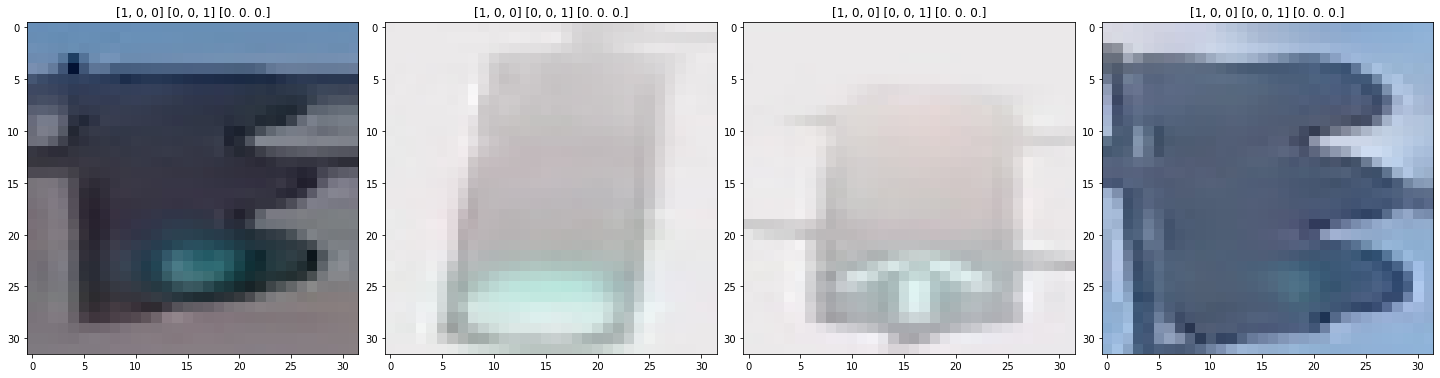

In [16]:
# visualize misclassified examples

fig = plt.figure(figsize=(20,40))

example_count = 24
if example_count>len(MISCLASSIFIED):
    example_count = len(MISCLASSIFIED)
    
chosen = set()

for cur_index in range(example_count):
    example_image = MISCLASSIFIED[cur_index][image_data_image_index]
    dom = get_color_dominance(example_image)
    result = "{} {} {}".format(MISCLASSIFIED[cur_index][1],MISCLASSIFIED[cur_index][2],dom)
    ax = fig.add_subplot(example_count, 4, cur_index+1, title = result)
    ax.imshow(example_image.squeeze())
fig.tight_layout(pad = 0.7)
    
    

In [17]:
# Test if you classify any red lights as green 

import test_functions
tests = test_functions.Tests()

if(len(MISCLASSIFIED) > 0):
    tests.test_red_as_green(MISCLASSIFIED)
else:
    print('MISCLASSIFIED may not have been populated with images.')

**<span style="color: green;">TEST PASSED</span>**

# 6. Improve algorithm (Use Deep Learning Model) 

In [25]:
# Traffic light detection using deeplearning

# prepare training set 
y_train = []
x_train = []

for index in range(len(STANDARDIZED_LIST)):
    x_train.append(STANDARDIZED_LIST[index][0])
    y_train.append(STANDARDIZED_LIST[index][1])
    
x_train = np.array(x_train)
y_train = np.array(y_train)


# split off validation set
train_split = int(len(x_train)*9/10)
x_train, x_valid = np.split(x_train,[train_split])
y_train, y_valid = np.split(y_train,[train_split])

# Load hidden testing set for real accuracy test
y_test = []
x_test = []

for index in range(len(STANDARDIZED_TEST_LIST)):
    x_test.append(STANDARDIZED_TEST_LIST[index][0])
    y_test.append(STANDARDIZED_TEST_LIST[index][1])
    
x_test = np.array(x_test)
y_test = np.array(y_test)

1187
1187
1068


In [30]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential 
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

tlcat_model = Sequential()

tlcat_model.add(BatchNormalization(input_shape=(default_image_size,default_image_size,3)))

tlcat_model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
tlcat_model.add(MaxPooling2D(pool_size=2))
tlcat_model.add(BatchNormalization())

tlcat_model.add(GlobalAveragePooling2D())

tlcat_model.add(Dense(3,activation = 'softmax')) # there three outputs(red, yellow and green)
tlcat_model.summary()
tlcat_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics = ['accuracy'])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_5 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 6, 6, 32)         

In [32]:
# Train the model

checkpointer = ModelCheckpoint(filepath = 'model.weight.traffic_lights.hdf5',verbose=1,
                               save_best_only = True)

tlcat_model.fit(x_train, y_train, batch_size=64, epochs =20,
               validation_data = (x_valid, y_valid), callbacks=[checkpointer],
               verbose=2,shuffle=True)

Train on 1068 samples, validate on 119 samples
Epoch 1/20
 - 2s - loss: 0.3168 - accuracy: 0.9036 - val_loss: 1.5922 - val_accuracy: 0.1681

Epoch 00001: val_loss improved from inf to 1.59219, saving model to model.weight.traffic_lights.hdf5
Epoch 2/20
 - 0s - loss: 0.0983 - accuracy: 0.9860 - val_loss: 0.6323 - val_accuracy: 0.7983

Epoch 00002: val_loss improved from 1.59219 to 0.63228, saving model to model.weight.traffic_lights.hdf5
Epoch 3/20
 - 0s - loss: 0.0609 - accuracy: 0.9869 - val_loss: 0.5976 - val_accuracy: 0.8571

Epoch 00003: val_loss improved from 0.63228 to 0.59762, saving model to model.weight.traffic_lights.hdf5
Epoch 4/20
 - 0s - loss: 0.0393 - accuracy: 0.9934 - val_loss: 0.2083 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.59762 to 0.20831, saving model to model.weight.traffic_lights.hdf5
Epoch 5/20
 - 0s - loss: 0.0222 - accuracy: 0.9963 - val_loss: 0.2508 - val_accuracy: 0.9916

Epoch 00005: val_loss did not improve from 0.20831
Epoch 6/20
 - 0s

In [35]:
tlcat_model.load_weights('model.weight.traffic_lights.hdf5')

In [42]:
# get index of predicted traffic light state for each image in test set
predictions = [np.argmax(tlcat_model.predict(np.expand_dims(feature,axis=0))) for feature in x_test]

# report test accuracy 
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(y_test, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.3266%


OpenCV test accuracy   : 98.6532%
Neural network accuracy: 99.3266%


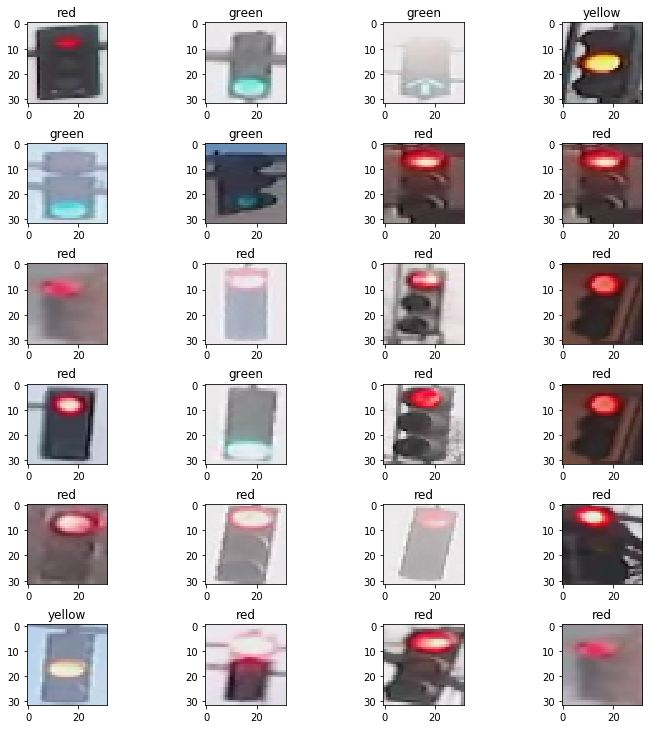

In [48]:
fig = plt.figure(figsize=(10,40))

chosen = set()

print('OpenCV test accuracy   : %.4f%%' % opencv_accuracy)
print('Neural network accuracy: %.4f%%' % test_accuracy)

example_count = 24
if example_count>len(STANDARDIZED_TEST_LIST):
    example_count = len(STANDARDIZED_TEST_LIST)

for example_index in range(example_count):
    tries = 0
    index = 0
    
    while tries<2:
        tries += 1
        index = random.randint(0, len(STANDARDIZED_TEST_LIST)-1)
        
        if index in chosen:
            continue
        chosen.add(index)
        
    example_image = STANDARDIZED_TEST_LIST[index][image_data_image_index]
    
    light_state = np.argmax(tlcat_model.predict(np.expand_dims(example_image, axis=0)))
    
    result = tl_states[light_state]
    ax = fig.add_subplot(total_count, 4, example_index+1, title=result)
    ax.imshow(example_image.squeeze())

fig.tight_layout(pad=0.7)